# Working with ShapeNet data 

In [2]:
import binvox_rw;
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d
import torch
import cv2
import os
import random
%matplotlib inline

In [3]:
with open('PlaneVoxels/1a04e3eab45ca15dd86060f189eb133/model.binvox','rb') as f:
    m1 = binvox_rw.read_as_3d_array(f)

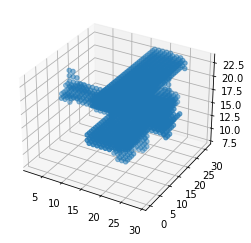

In [4]:
arr = m1.data
xx,yy,zz = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]), np.arange(arr.shape[2]))

flat_arr = arr.flatten()
coords = np.vstack( (xx.flatten(), yy.flatten(), zz.flatten()) )
occupied_coords = coords[:,flat_arr]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(occupied_coords[1,:], occupied_coords[2,:], occupied_coords[0,:])
plt.show()

In [5]:
for i in os.listdir('PlaneRenderings'):
    if not os.path.isdir(f'PlaneVoxels/{i}'):
        print('Ur fucked')

### Voxels contains all Renderings ... Not the other way around.

In [6]:
def makeData(path):
    all_png = [path+i for i in os.listdir(path) if i.endswith('.png')]
    choices = random.sample(all_png,k=5)
    return choices
def makeLabel(path):
    with open(path+'/model.binvox','rb') as f:
        m1 = binvox_rw.read_as_3d_array(f)
    return m1.data

In [7]:
list_png = makeData('PlaneRenderings/7a57a9b261f60dcb2296d88107d065f6/rendering/')

In [8]:
occ_grid = makeLabel('PlaneVoxels/7a57a9b261f60dcb2296d88107d065f6/')

In [9]:
occ_grid = torch.tensor(occ_grid.astype(np.uint8)).long().reshape(1,32,32,32)
occ_grid = occ_grid.cuda()

In [10]:
list_png

['PlaneRenderings/7a57a9b261f60dcb2296d88107d065f6/rendering/16.png',
 'PlaneRenderings/7a57a9b261f60dcb2296d88107d065f6/rendering/18.png',
 'PlaneRenderings/7a57a9b261f60dcb2296d88107d065f6/rendering/22.png',
 'PlaneRenderings/7a57a9b261f60dcb2296d88107d065f6/rendering/00.png',
 'PlaneRenderings/7a57a9b261f60dcb2296d88107d065f6/rendering/21.png']

### Running FullNetwork through data

In [11]:
from model import EncodeNetwork, LSTM_Network, DecodeNetwork

In [12]:
enc = EncodeNetwork()
enc = enc.cuda()

lstm = LSTM_Network()
lstm = lstm.cuda()

dec = DecodeNetwork()
dec = dec.cuda()

cross_entropy = torch.nn.NLLLoss()

In [13]:
import time
start = time.time()
h0 = torch.zeros((128, 4, 4, 4)).cuda()
s0 = torch.zeros((128, 4, 4, 4)).cuda()
for i in range(len(list_png)):
    im = cv2.imread(list_png[i])
    im = cv2.resize(im, (127,127), interpolation=cv2.INTER_AREA)
    im.transpose(2,0,1)
    im = torch.tensor(np.rollaxis(im,2,start=0), device='cuda')
    im = im.float()
    s0,h0 = lstm(enc(im),s0,h0)
h1_res = h0.reshape((1,)+h0.shape)
decoded = dec(h1_res)
print(time.time() - start)

1.833146572113037


In [15]:
a = cross_entropy(decoded, occ_grid)

In [16]:
test = 0
test += a

In [20]:
print( (test + a)/2 )

tensor(0.7071, device='cuda:0', grad_fn=<DivBackward0>)


## Making a dataset for DataLoader

In [14]:
import torch.utils.data as data

In [15]:
class R2N2_Data(data.Dataset):
    def __init__(self, path_to_data, path_to_labels):
        self.root_data = path_to_data
        self.root_labels = path_to_labels
        self.dataPointsFileNames = os.listdir(path_to_data)
        self.n = len(self.dataPointsFileNames)
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        directory = self.root_data + self.dataPointsFileNames[idx]
        os.listdir(directory)
        all_png = [directory+'/rendering/'+i for i in os.listdir(directory + '/rendering/') if i.endswith('.png')]
        choices = random.sample(all_png,k=5)
        images = []
        for path in choices:
            im = cv2.imread(path)
            im = cv2.resize(im, (127,127), interpolation=cv2.INTER_AREA)
            im.transpose(2,0,1)
            im = torch.tensor(np.rollaxis(im,2,start=0), device='cuda').float()
            images.append(im)
        with open(self.root_labels + self.dataPointsFileNames[idx] + '/model.binvox','rb') as f:
            m1 = binvox_rw.read_as_3d_array(f)
        occ_grid = m1.data
        occ_grid = torch.tensor(occ_grid.astype(np.uint8)).long()
        occ_grid = occ_grid.cuda()
        
        data_dict = {'data': images, 'label': occ_grid}
        return data_dict

In [16]:
dataset = R2N2_Data('PlaneRenderings/', 'PlaneVoxels/')
train_loader = udata.DataLoader(dataset=dataset, batch_size=10, shuffle=True, num_workers=0, drop_last=True)

## Testing Neural Network on a Batch of Data

In [17]:
dataset = R2N2_Data('PlaneRenderings/', 'PlaneVoxels/')
batches = udata.DataLoader(dataset=dataset, batch_size=10, shuffle=True, num_workers=0, drop_last=True)

In [18]:
adam = torch.optim.Adam([ {'params': enc.parameters()}, {'params': lstm.parameters()}, {'params': dec.parameters()}], lr=0.001)
nll = torch.nn.NLLLoss()

In [21]:
start = time.time()
for idx,data in enumerate(batches):
    adam.zero_grad()
    occ_grid = data['label']
    h0 = torch.zeros((128, 4, 4, 4)).cuda()
    s0 = torch.zeros((128, 4, 4, 4)).cuda()
    for im in data['data']:
        s0,h0 = lstm(enc(im).cuda(),s0,h0)
    decoded = dec(h0.cuda()).cuda()
    loss = nll(decoded, occ_grid).cuda()
    loss.backward()
    adam.step()
print(time.time() - start)

117.83453750610352
